In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchsummary import summary
from torch import linalg as LA
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch import linalg as LA


class P_Net(nn.Module):
    """ Input format is [b,c,h,w] , it outputs norms of output feature map if final is true
        else outputs feature map of same formate as input.
        The feature map transforms as [b,n,d,d]->[b,k,d,d]
        where n(on of input planes),k(no of output planes) and d(dim of each planes)
    """

    def __init__(self,in_units,out_units,units_dim,share_weights=True,final=False,**args):
        super(P_Net, self).__init__()
        self.n = in_units
        self.k = out_units
        self.d = units_dim
        self.final=final

        # module parameters

        if(args):
          #self.R = torch.ones([1,self.n,self.k])
          self.R = nn.parameter.Parameter(data=torch.ones([1,self.n,self.k]),requires_grad=False)
        else:
          self.R = nn.parameter.Parameter(data=torch.empty(1,self.n,self.k),requires_grad=True)
          nn.init.xavier_uniform_(self.R,gain=1.414) # initializing the weights.


        if(share_weights):
            """ W is 'nk-shared' i.e it is shared among k classes and n feature maps"""
            self.W = nn.parameter.Parameter(data=torch.empty(1,self.d,self.d),requires_grad=True)
            nn.init.xavier_uniform_(self.W,gain=1.414) # initializing the weights.
        else:
            """ Indentity transformation if set true """
            I = torch.eye(self.d).reshape([1,self.d,self.d])
            self.W = nn.parameter.Parameter(data=I,requires_grad=False)



    def forward(self, x):
        #R_nor = F.softmax(self.R, dim=1)
        #R_nor = constrain(self.R)
        W_s = torch.tile(self.W,[1,self.n,1,1])
        x = torch.matmul(W_s,x)
        x = torch.unsqueeze(x,dim=2)
        x = torch.tile(x,dims=[1, 1, self.k, 1, 1])
        x = torch.mul(x,torch.reshape(self.R, shape=[1, self.n, self.k, 1, 1]))
        x = torch.sum(x,dim=1)
        x = F.relu(x)
        if(self.final):
            x = LA.matrix_norm(x+1e-7,ord='fro',dim=(-2,-1))
        return x

In [ ]:
class AlexNet(nn.Module):
    def __init__(self,num_class=10,final = True):
        super(AlexNet,self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(6, 12, kernel_size=5, stride=1,padding=0),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(12, 24, kernel_size=3, stride=2,padding=0),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size = 2, stride=2),
            )

        self.classifier = nn.Sequential()
        if(final):
            self.classifier = P_Net(24, num_class, 7,final=False)

        self.feature_maps = 0
        self.class_representor = 0


    def forward(self, x):
        x = self.net(x)
        self.feature_maps = x
        x = self.classifier(x)
        self.class_representor = x
        x = LA.matrix_norm(x+1e-7,ord='fro',dim=(-2,-1))
        return x



In [ ]:
# import torch
# import numpy as np


class Model_trainer():

    def __init__(self,class_labels: list, device='cpu'):
        self.test_loss = []
        self.train_loss = []
        self.test_acc = []
        self.train_acc = []
        self.classes = class_labels
        self.prediction: dict
        self.prevepoch_acc = float('inf')
        self.device = device

    def train_loop(self, dataloader, model, loss_fn, optimizer):
        model.train()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        train_loss = 0
        correct = 0

        for batch, (X, y) in enumerate(dataloader):
            X = X.to(self.device)
            y = y.to(self.device)
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)
            train_loss += loss.item()

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= num_batches
        correct /= size
        return train_loss,correct

    def test_loop(self, dataloader, model, loss_fn):
        model.eval()

        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss = 0
        correct = 0

        y_pred = []
        y_true = []

        with torch.no_grad():
            for X, y in dataloader:
                X = X.to(self.device)
                y = y.to(self.device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()

                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

                y_pred.append(torch.argmax(pred,dim=-1).cpu().numpy())
                y_true.append(y.cpu().numpy())

        test_loss /= num_batches
        correct /= size
        return test_loss,correct,{'y_pred':y_pred,'y_true':y_true}


    def fit(self,trainloader, testloader, model, loss_fn, optimizer, scheduler = None, epochs=30, verbose=False):
        for t in range(epochs):
            train_loss,train_acc = self.train_loop(trainloader, model, loss_fn, optimizer)
            test_loss,test_acc,prediction = self.test_loop(testloader,model, loss_fn)
            if(scheduler != None):
                scheduler.step(test_loss)
            self.train_loss.append(train_loss)
            self.test_loss.append(test_loss)
            self.train_acc.append(train_acc)
            self.test_acc.append(test_acc)
            if(self.prevepoch_acc < test_acc):
                self.prediction = prediction
                if(verbose):
                  print('saving model predictions')
            self.prevepoch_acc = test_acc
            print('Epoch: %d, Train Acc: %.5f, Test Acc: %.5f'%(t+1,train_acc,test_acc))

        self.prediction['y_pred'] = np.concatenate(self.prediction['y_pred'])
        self.prediction['y_true'] = np.concatenate(self.prediction['y_true'])
        return {'Train_loss':self.train_loss,'Test_loss':self.test_loss,'class_label':self.classes,'Train_acc':self.train_acc,'Test_acc':self.test_acc},self.prediction


In [ ]:
!ls ../input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages

Cat  Dog


In [ ]:
data_path = '../input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages/'


transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

dataset = datasets.ImageFolder(data_path, transform=transform)

train_dataset,test_dataset = torch.utils.data.random_split(dataset,[.8,.2])

print(dataset.classes)
n_classes = len(dataset.classes)

['Cat', 'Dog']


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=128,num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=128,num_workers=2)

In [ ]:
model = AlexNet(num_class=2,final=True)

x = torch.randn(1,3,128,128)
output = model(x)
print(f'model output shape: {output.shape}.')

model = model.to(device)

total_params=sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {total_params}.')

loss = nn.CrossEntropyLoss()

model output shape: torch.Size([1, 2]).
Total trainable parameters: 4981.


In [ ]:
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                                                   mode='min',
#                                                   factor=0.5,
#                                                   patience=2,
#                                                   threshold=0.0001,
#                                                   min_lr=1e-7,
#                                                   verbose=True)

# epochs = 50
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train_loop(trainloader, model, loss, optimizer)
#     test_loss = test_loop(testloader, model, loss)
#     scheduler.step(test_loss)
# print("Done!")

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                  mode='min',
                                                  factor=0.5,
                                                  patience=2,
                                                  threshold=0.001,
                                                  min_lr=1e-7,
                                                  verbose=True)

model_trainer = Model_trainer(dataset.classes, device=device)

In [ ]:
history,prediction = model_trainer.fit(train_loader,test_loader,model,loss,optimizer,scheduler,epochs=30)

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 1, Train Acc: 0.58263, Test Acc: 0.60048


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 2, Train Acc: 0.61418, Test Acc: 0.62613


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 3, Train Acc: 0.63977, Test Acc: 0.63474


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 4, Train Acc: 0.65445, Test Acc: 0.66119


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 5, Train Acc: 0.66857, Test Acc: 0.66600


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 6, Train Acc: 0.68129, Test Acc: 0.67742


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 7, Train Acc: 0.69306, Test Acc: 0.69425


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 8, Train Acc: 0.69466, Test Acc: 0.69265


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 9, Train Acc: 0.70463, Test Acc: 0.70687


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 10, Train Acc: 0.71204, Test Acc: 0.69906


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 11, Train Acc: 0.72266, Test Acc: 0.70747


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 12, Train Acc: 0.72756, Test Acc: 0.71809


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 13, Train Acc: 0.72982, Test Acc: 0.72651


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 14, Train Acc: 0.74124, Test Acc: 0.73332


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 15, Train Acc: 0.74639, Test Acc: 0.74194


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 16, Train Acc: 0.74549, Test Acc: 0.74073


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 17, Train Acc: 0.74810, Test Acc: 0.73953


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 18, Train Acc: 0.74905, Test Acc: 0.71649


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 19, Train Acc: 0.75280, Test Acc: 0.75356


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 20, Train Acc: 0.75972, Test Acc: 0.74194


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 21, Train Acc: 0.76307, Test Acc: 0.73292


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 22, Train Acc: 0.76833, Test Acc: 0.75977


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 23, Train Acc: 0.76552, Test Acc: 0.74153


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 24, Train Acc: 0.77359, Test Acc: 0.76658


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 25, Train Acc: 0.77579, Test Acc: 0.75937


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 26, Train Acc: 0.77965, Test Acc: 0.76257


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 27, Train Acc: 0.78205, Test Acc: 0.77720


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 28, Train Acc: 0.78691, Test Acc: 0.78081


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 29, Train Acc: 0.79092, Test Acc: 0.77940


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 30, Train Acc: 0.79026, Test Acc: 0.78481


In [ ]:
from sklearn import metrics

In [ ]:
print(metrics.classification_report(prediction['y_true'],prediction['y_pred'], digits=3))

              precision    recall  f1-score   support

           0      0.804     0.760     0.782      2528
           1      0.767     0.810     0.788      2463

    accuracy                          0.785      4991
   macro avg      0.786     0.785     0.785      4991
weighted avg      0.786     0.785     0.785      4991



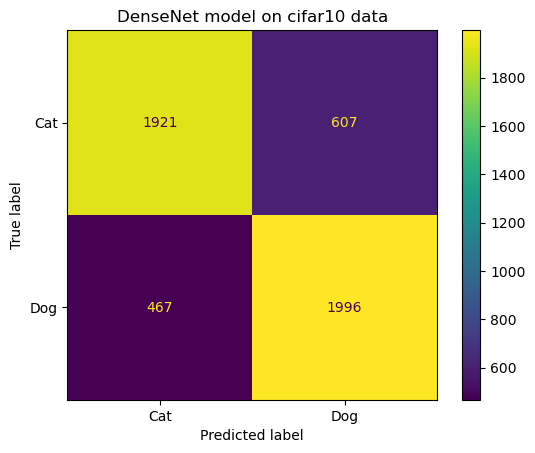

In [ ]:
confusion_matrix = metrics.confusion_matrix(prediction['y_true'],prediction['y_pred'])
img = metrics.ConfusionMatrixDisplay(confusion_matrix,display_labels=history['class_label'])
img.plot()
plt.title('DenseNet model on cifar10 data')
plt.show()

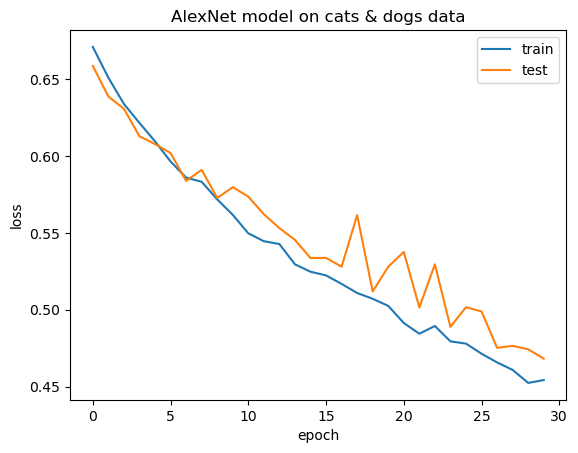

In [ ]:
plt.plot(history['Train_loss'])
plt.plot(history['Test_loss'])
plt.title('AlexNet model on cats & dogs data')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

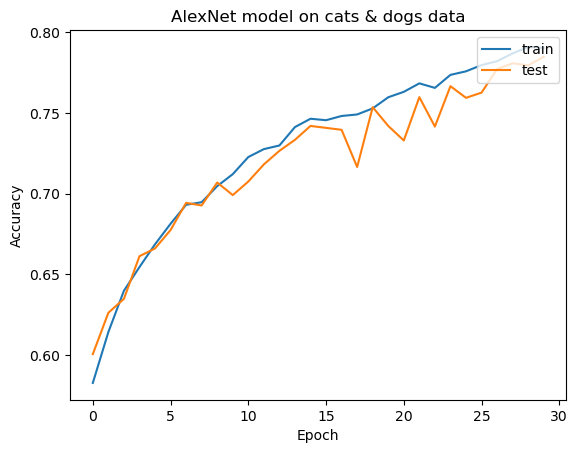

In [ ]:
plt.plot(history['Train_acc'])
plt.plot(history['Test_acc'])
plt.title('AlexNet model on cats & dogs data')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

In [ ]:
dataiter = iter(test_loader)

In [ ]:
images, labels = next(dataiter)
images = images.to(device)

In [ ]:
images.shape

torch.Size([1, 3, 128, 128])

In [ ]:
labels

tensor([1])

In [ ]:
output = model(images)
torch.argmax(output)

tensor(1)

In [ ]:
img = images.cpu().numpy()

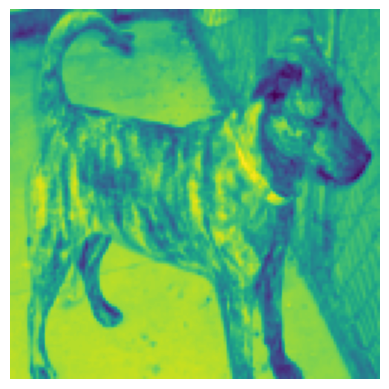

In [ ]:
plt.imshow(img[0][0])
plt.axis('off')
plt.show()

In [ ]:
X = model.feature_maps.cpu().detach().numpy()

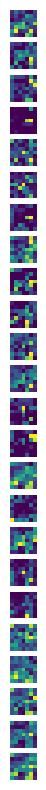

In [ ]:
fig = plt.figure(figsize=(30, 10))

rows = 24
columns = 1

for i in range(24):
  fig.add_subplot(rows, columns, i+1)
  # showing image
  plt.imshow(X[0][i])
  plt.axis('off')

plt.show()

In [ ]:
Z = model.class_representor.cpu().detach().numpy()

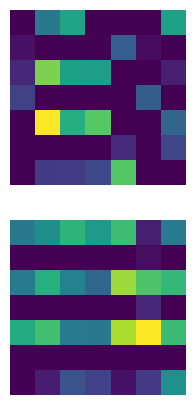

In [ ]:
fig = plt.figure(figsize=(10, 5))

rows = 2
columns = 1

for i in range(2):
  fig.add_subplot(rows, columns, i+1)
  # showing image
  plt.imshow(Z[0][i])
  plt.axis('off')

plt.show()

In [ ]:
pred = output.cpu().detach().numpy()
pred = np.reshape(pred,[1,2,1])

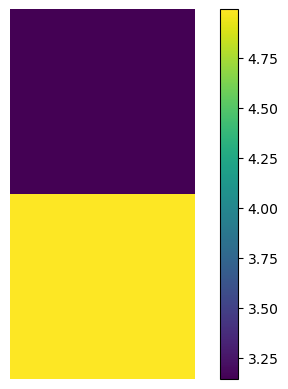

In [ ]:
prd = plt.imshow(pred[0])
plt.axis('off')
cbar = plt.colorbar(prd)
plt.show()

In [ ]:
R = model.classifier.R.cpu().detach().numpy()

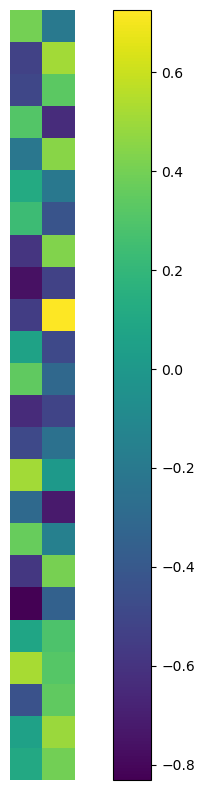

In [ ]:
fig = plt.figure(figsize=(10, 10))
im = plt.imshow(R[0])
plt.axis('off')
cbar = plt.colorbar(im)
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

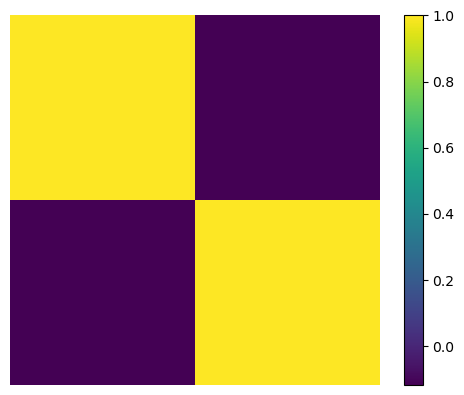

In [ ]:
im = plt.imshow(cosine_similarity(R[0].T))
plt.axis('off')
cbar = plt.colorbar(im)
plt.show()

In [ ]:
W = model.classifier.W.cpu().detach().numpy()

In [ ]:
X.shape,W.shape

((1, 24, 7, 7), (1, 7, 7))

In [ ]:
X_trans = np.matmul(X,W)

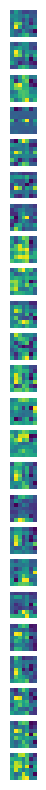

In [ ]:
fig = plt.figure(figsize=(30, 10))

rows = 24
columns = 1

for i in range(24):
  fig.add_subplot(rows, columns, i+1)
  # showing image
  plt.imshow(X_trans[0][i])
  plt.axis('off')

plt.show()